In [12]:
from IPython.display import Image

#### palavras chaves - Entendendo um pouco

[fonte] https://pagar.me/blog/o-que-quer-dizer-psp-no-mercado-de-meios-de-pagamento-online/

- Adquirentes - "maquininha de cartão" - comunica com o banco.

- Intermediadores/subadquirentes -  "uma pessoa que te aluga uma maquininha de cartão" - faz sentido pois no ecomerce há mais questões, exemplo fraude, esse cara resolve isso para você. Melhor quando pequeno. Pode abrir uma janela nova para fazer as compras. "Mó rolê".

- Gateways - entre a maquininha e o cliente, mais barato em escala, mais difícil de implementar. O risco pode ficar com você. A sua página processa o pagamento.

- PSP - Parrudo igual gateway, prático como um subadquirente. É um "gateway com UX" e podendo ser mais flexível.

- chargeback - cancelamento por N motivos; arrependimento até fraude.


Portanto o caminho é Cliente > SubAd/Gateway/PSP > adquirinte > Loja  

#### Racional por trás da resolução - Entendendo um pouco

Primeiro passo foi entender que era transação por tipo. Segundo foi entender qual tabela seria a balizadora das minhas queries; quem estaria no "from". Teoricamente qualquer um funionaria, mas há uma questão semântica na reasolução do problema e portanto o começo permite ser uma solução mais ou menos intuitiva. 

Como no começo é muito nebulso, comecei trabalhando com cada tabela para transformar para N:1, quando possível. <br>
As tabelas transaction e companies já o são naturalmente. A transctionOps e payables não o são, contudo payables tem a única informação importante, o gateway_fee.<br>
Assim ficando com transctionOps a tabela principal no qual resultará na tabela fato.

### Há 7 passos para resolução


#### Passo 0: Rodar o notebook create_table.ipynb .  Esse notebook irá criar um PostgreSQL e irá inserir os dados

#### Passo 1: acessando o dbeaver

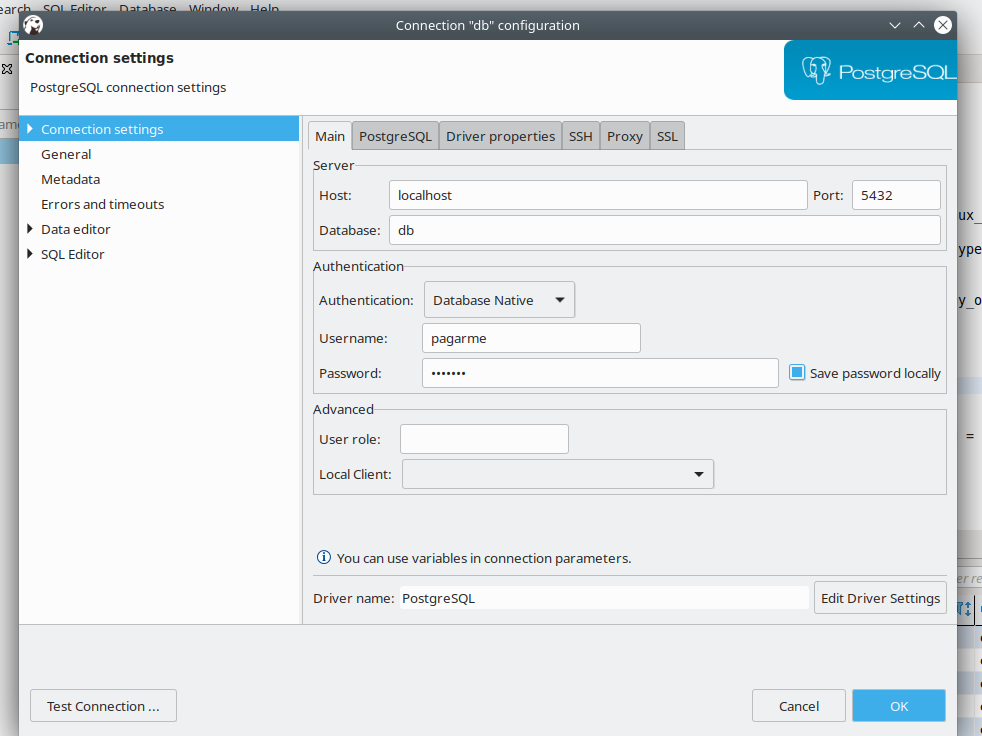

In [17]:
"""
acessando o dbeaver ou qualquer outro conector.
Usei um Dbeaver da vida, ao invés do python, pois o output é mais otimizado para isso.
"""
Image(filename='img/config_dbeaver.png')

#### Passo 2: entendendo o fluxo de tabelas pelo time stamp de cada select

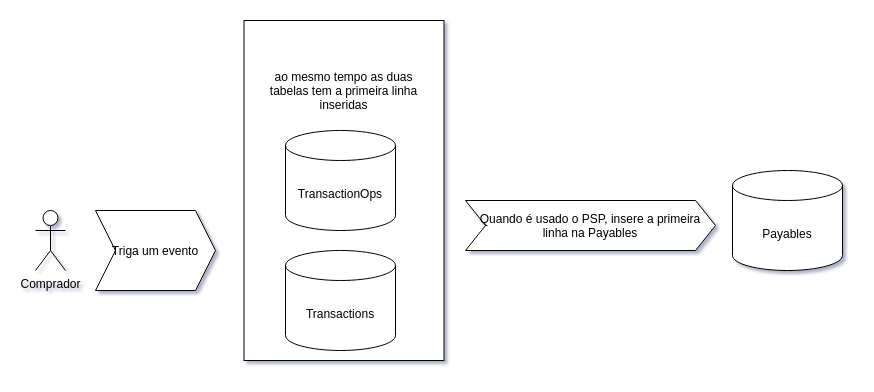

In [21]:
"""
select * from transactions t2 where transaction_id = 'e9d9d6385f' 

select * from "transactionOperations" to2  where transaction_id = 'e9d9d6385f'

select * from payables p  where transaction_id = 'e9d9d6385f'
"""
Image(filename='img/fluxo_inserts.png')

#### Passo 3: Lendo o arquivo raw/enunciado-case_dw.pdf e desenhando a bus matriz, kinda_bus_matrix.xlsx

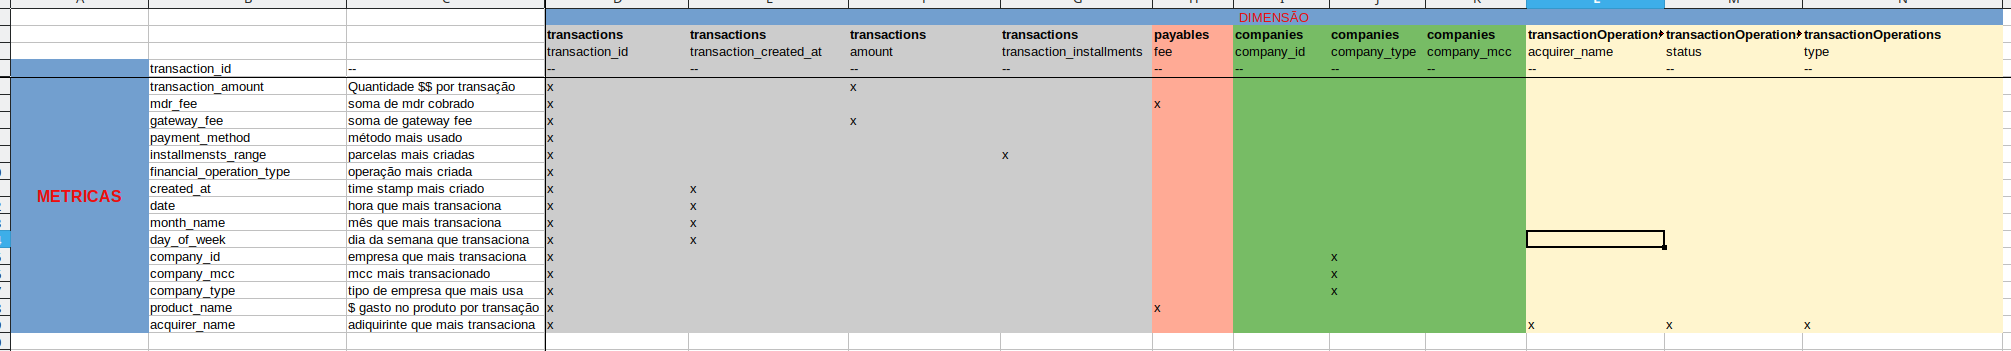

In [22]:
"""
3.0 Basicamente é entender as dimensões para a tabela fato e colocar um nível de semântica 
    nas colunas requeridas 
3.1 Adotei um star schema
3.2 A granularidade será para transaction_id

3.3 Observe que "acquirer_name" e "type" irão multiplicar com a linha de "transaction_id".
Pessoalmente eu achei estranho, mas creio que o pessoal aí esteja acostumado
"""
Image(filename='img/kinda_bus_matrix.png')

#### Passo 4: Fazendo o SQL

Utilizo tabelas temporarias para fazer a query pois acredito que fique mais limpo assim. <br> 
Talvez se uma tabela CTE for usada em mais de um job, seja legal materializa la.<br>
De qualquer forma, separar os componenetes fica mais fácil de ler/ dar manutenção.

sobre as tabelas CTE:

- payables_cte : Utilizei um "row_number over partition by", pois acreditava que iria usar a chave primária da payables, o que foi mentira. Outra opção seria usar um distinct, mas eu não sou fã pois, num futuro de manutenção e adiconar colunas, comportamentos estranhos podem aparecer.   


- transactions_cte: utilizo um "Case/when" para discretizar  o numero de parcelas. Uma opção seria fazer union com 3 queries com filtro de datas. Digo isso pois case pode ser bem lento, como há poucos registros não há problema. Pode se argumentar que case é mais legível, e portanto mais fácil de dar manutenção. Acho que cabe um debate e um teste. 


- transactionops_cte: um grande desafio foi transformar UTC para o horário de Brasília, -3 no caso. Esse não é uma solução muito elegante na medida que em horário de verão isso quebra. Algo mais simples é mudar o horário dentro do servidor ou dentro do seu banco. 


- companies_cte: essa tabela já é 1:1 então não preciso arrumar.


In [ ]:
###################A query em si


with payables_cte as(
	select transaction_id as transaction_id_p , abs(fee) as mdr_fee
	from(
		select type, row_number() over (PARTITION by transaction_id order by (payable_created_at, installment) desc) as RN, *	
		from payables p 
	) X
	where X.RN =1)
	
	,transactions_cte as(
		select transaction_id as transaction_id_t
		,company_id
		,payment_method
		,amount as transaction_amount
		,gateway_fee
		,case when transaction_installments = 1 then 'a vista' 
   			when transaction_installments between 2 and 6 then '2-6'
			when transaction_installments between 7 and 12 then '7-12'
    	 end installments_range
    	 from  transactions
    	 where payment_method like '%_card') 
    	 
	,transactionops_cte as (
		select 	
				type as financial_operation_type
				,transaction_id
				,acquirer_name
				,transaction_created_at::time as created_at , transaction_created_at::date as date
				,to_char(transaction_created_at,'month') as month_name,extract (dow from transaction_created_at) as day_of_week
				
		from ( select  transaction_operation_created_at - '3 hour'::interval  as transaction_created_at, *
				from "transactionOperations" to2 
			    where  (to2.type = 'capture' or to2.type = 'refund' or  to2.type = 'chargeback_refund' or to2.type = 'chargeback') and status = 'success'
			   ) x
	)
		
	, companies_cte as(
	 	select company_id as company_id_c, company_mcc, company_type from companies 
	)
	
	
select 
		case when (A.financial_operation_type = 'refund') or (A.financial_operation_type= 'chargeback') then -1*C.transaction_amount else C.transaction_amount end transaction_amount
		,case when (A.financial_operation_type = 'refund') or (A.financial_operation_type ='chargeback') then -B.mdr_fee else B.mdr_fee end mdr_fee
	   	,case when (A.financial_operation_type = 'refund') or (A.financial_operation_type= 'chargeback') then 0 else C.gateway_fee end gateway_fee
		,A.transaction_id, C.payment_method
		,C.installments_range, A.financial_operation_type, A.created_at, A.date , A.day_of_week
		,C.company_id, C.company_mcc, C.company_type
		,case when  B.mdr_fee isnull then 'gateway' else 'psp' end product_name
		,A.acquirer_name
	   
from transactionops_cte A
left join payables_cte B
	on A.transaction_id = B.transaction_id_p 
inner join (select * from transactions_cte X inner join companies_cte Y on X.company_id = Y.company_id_c ) C
	on A.transaction_id = C.transaction_id_t
order by A.transaction_id 



#### Passo 5: testando

teste1 :
    select * from transactions t2 where transaction_id = 'e9d9d6385f' 
    select * from "transactionOperations" to2  where transaction_id = 'e9d9d6385f'
    select * from payables p  where transaction_id = 'e9d9d6385f'
     
    --compara
    roda a query da célula de cima com where transaction_id = 'e9d9d6385f'


--------------------------------------------------------------------------------------

teste2 :
    select * from payables p2 where transaction_id = '15e186fb43'
    select * from transactions t2  where transaction_id = '15e186fb43'
    select * from "transactionOperations" to2 where transaction_id = '15e186fb43'
    
    --compara
    roda a query da célula de cima com where transaction_id = '15e186fb43' 


--------------------------------------------------------------------------------------
teste3:
    select count(1) 
    from transactions
    where payment_method like '%_card'


--------------------------------------------------------------------------------------
teste4:
select count(1)
	from(
		select type, row_number() over (PARTITION by transaction_id order by (payable_created_at) desc) as RN, *	
		from payables p 
	) X
	where X.RN =1

--------------------------------------------------------------------------------------
teste5: 
from transactions
where payment_method like '%_card'


#### Passo 6: exportando os dados
os dados estão no query_results.csv